# Investigating the CORD-19 Dataset using Latent Dirichlet Allocation (LDA)
***

**Candidate Number: 35946**

## Executive Summary
***

This report seeks to find pertinent topic clusterings in the CORD-19 Dataset [1]. The research community is currently struggling to handle the vast amounts of information coming in regarding COVID-19. We can show that it's possible to cluster together similar documents and we make use of the convenient features of Apache Spark's MLlib, to demonstrate the effectiveness of both Online and Batch Variational Bayes methods for estimating the posterior distribution needed for Latent Dirichlet Allocation.

We present methods to validate an LDA models fit and in addition to this provide insight into the data through showing the most relevant documents for each topic and providing a tool to recommend the most similar paper for a given paper ID using the Jenson-Shannon distance.

## 1. Introduction
****
### Background Information
When confronted with a large volume of text or text corpus it is useful to be able to analyse and form an orderly view of the corpus relatively quickly so that you can find relevant documents and draw insight from them.
Latent Dirichlet Allocation (LDA) is a generative statistical model or natural language processing technique whereby when applying to a text corpus we can form a topic model. A topic model is simply used to extract abstract topics in a large text corpus, and we will now outline what LDA does to achieve this. <br>

Latent Dirichlet Allocation was first introduced in 2003 by Blei et al. [2], it assumes that documents are created in the following __generative process:__<br>

- __1.__ Set the number of words in a document. Let's say $N_i$<br>

- __2.__ Choose a topic mixture for the document i.e. (Topic 1: 30%, Topic 2: 40%, Topic 3: 30%)<br>
Choose $\theta_i$ ~ Dirichlet($\alpha$) where i$\in$  {1,...M}. M the number of documents. $\theta$ represents the topic distribution.
- __3.__ Generate the words in the document from the above topic distribution, thus forming a document.<br>
Choose $\gamma_k$ ~ Dirichlet($\beta$), where k$\in$ {1,...,K}. K the number of topics. $\gamma$ is the word distribution.<br>
For each of the words in a document, choose a topic $z_{i,j}$ ~ Multinomial($\theta_i$), where $z_{i,j}$ is ith word in the nth document.<br> Then choose a word $w_{i,j}$ ~ Multinomial($\gamma_{z_{i,j}}$).


So how can we use this to determine K topics in a corpus?<br> This is a tricky as we must reverse engineer the generative process.
To do this we must learn the various distributions described in the steps above. Specifically, we must calculate the posterior distribution. This however is intractable, so we need to estimate it instead. This report will specifically look at two ways of estimating the posterior distribution, __batch variational bayes__ and __online variational bayes__ (Hoffman et al., 2011) [3] inference. The idea is that we approximate the posterior distribution P with a simpler distribution that we deem tractable Q. We then form this is an optimization problem where we are trying to maximise the evidence lower bound (ELBO), and this helps us minimise the Kullback-Leibler divergence between the two distributions P and Q.

Other methods to estimate the posterior include sampling methods such as Gibbs Sampling. The downfall of such methods are that they don't scale as well as variational inference techniques. This is why Spark being that it is built for distributed data analytics only includes the variational inference methods for estimating the posterior.

### CORD-19 Dataset

The [CORD-19 Dataset](https://www.semanticscholar.org/cord19) is a collection of over 59,000 scholarly articles with over 49,000 of full text about COVID-19 and other viruses in the family coronaviruses such as the SARS virus. The initiative is backed by The White House and partnered with companies like Mircosoft and the Allen Institute for AI.

The full dataset is roughly 8GB in size and has a non commercial use subset that we can work with containing 2584 documents. The data is solely stored in the semi-structured JSON format. This dataset seems ripe for this kind of task as we have a large amount of data for LDA to learn from and it's important for researchers to be able to get their hands on the information that they need as soon as possible so that we can control the pandemic. Reserachers would often like that given a paper and all of the documents available for the coronaviruses, which papers are most relevant for them to study next? We address this in the report.

Documents are collected from the following sources: CZI (Chan Zuckerburg Initiative), PMC (Pub Med), BioRxiv and MedRxiv.

### Research Question

_How can we use Latent Dirichlet Allocation (LDA) and it's distributed implementations in Spark to find relevant articles in the CORD-19 Dataset?_


## 2. Preparing the Corpus for LDA
***

To use Spark MLlib's LDA model implementation, we need to format our data into a DataFrame where we have the paper ID in one column and then the text for that paper in another column. To elaborate, we must also tokenize each paper's text and remove any [stopwords](https://en.wikipedia.org/wiki/Stop_words) [4].

### Project Dependencies

In [1]:
# Any ambiguous library usages I have chosen to leave them
# in the cells where they were first used.
import nltk
from pyspark.sql.functions import *
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import os
from pyspark.mllib.feature import HashingTF, IDF
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
import time
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce 
from pyspark.sql import DataFrame

In [2]:
# What is the default number of partitions for our SparkContext?

sc.defaultParallelism

2

### Load in the CORD-19 Dataset

In [3]:
# Retrieve the JSON documents from GCP Bucket and load them into Spark

path = "gs://gtbucket1/cord/pdf_json/*.json"

cord19 = spark.read.json(path, multiLine = True)

In [4]:
# Here we can see the schema of the JSON Files. About 3/4 way down after BIBREF's you can see
# more important information such as Paper ID, Document Text, etc.

cord19.printSchema()

root
 |-- abstract: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cite_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |-- ref_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |-- section: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |-- back_matter: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cite_spans: array (nullable = true)
 |    |    

In [5]:
cord19.take(1)

[Row(abstract=[Row(cite_spans=[], ref_spans=[], section='Abstract', text='E8 piuttosto che articoli eccellenti al termine del processo decisionale. Egli conclude suggerendo che la sintesi accurata delle evidenze disponibili è il contributo più importante che il mondo accademico può dare al processo decisionale, anche in termini di valutazione economica degli interventi sanitari, atteso che i responsabili delle politiche sanitarie prendono decisioni che implicano l\'utilizzo di cospicue risorse economiche. L\'aumento della pressione economica impone la necessità di scegliere "saggiamente" e investire su ciò che "funziona" per migliorare la salute della comunità.'), Row(cite_spans=[], ref_spans=[], section='Abstract', text='Come è noto, l\'implementazione degli interventi orientati a tutelare la salute pubblica, spesso, comporta costi elevati e solo attraverso un percorso di valutazione è possibile garantire che le risorse vengano impiegate in modo appropriato ed efficiente, evitando di 

### Data Cleaning

In [6]:
# Filter the DataFrame such that we only have paper_id and text of the documents

cord19text = cord19.select("paper_id","body_text")

In [7]:
# This is the part of each JSON document that we are interested in, referred to above.
# We must now access these deeper parts of body_text, to extract the actual body of each document.

cord19text.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- body_text: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cite_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |-- ref_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end: long (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |    |    |-- start: long (nullable = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |-- section: string (nullable = true)
 |    |    |-- text: string (nullable = true)



In [8]:
# The CORD-19 Dataset seems to save the body of a document split into sections
# this is why we see duplicate paper_id's. We have used SQL explode command
# to extract the part that we want - "text".

cord19text = cord19text.select("paper_id",explode('body_text').alias('tmp')).select("paper_id",'tmp.text')
cord19text.show()

+--------------------+--------------------+
|            paper_id|                text|
+--------------------+--------------------+
|ce6717ad3bb0da860...|Nel promuovere e ...|
|ce6717ad3bb0da860...|L'obiettivo princ...|
|ce6717ad3bb0da860...|P. CONTU Dipartim...|
|ce6717ad3bb0da860...|Il topo costruisc...|
|ce6717ad3bb0da860...|Fino a pochi dece...|
|ce6717ad3bb0da860...|Il SSN (Legge 833...|
|ce6717ad3bb0da860...|Documenti interna...|
|ce6717ad3bb0da860...|Migliorare la sal...|
|ce6717ad3bb0da860...|Angelillo B e Rom...|
|ce6717ad3bb0da860...|La produzione del...|
|ce6717ad3bb0da860...|Le conoscenze sci...|
|ce6717ad3bb0da860...|L'antimicrobico-r...|
|ce6717ad3bb0da860...|Il Gruppo Italian...|
|ce6717ad3bb0da860...|Il progetto SPIN-...|
|ce6717ad3bb0da860...|La valutazione de...|
|ce6717ad3bb0da860...|Non vi è dubbio c...|
|ce6717ad3bb0da860...|L'analisi dei dat...|
|ce6717ad3bb0da860...|Gestione delle di...|
|ce6717ad3bb0da860...|Buone pratiche pe...|
|ce6717ad3bb0da860...|Il progett

### How important is it to choose the correct number of partitions for the data?

In [9]:
# We show how important it is to make use of Spark's partitioning features when making a K,V pair rdd

def get_partition_speed(data, partitions):
    
    time_array = np.zeros(2*len(partitions)).reshape(len(partitions),2)

    for i in range(len(partitions)):
        time_array[i][0] = partitions[i]
        rdd = data.rdd.map(lambda x: (x[0],x[1])).reduceByKey(lambda x,y: x+y).partitionBy(partitions[i])
        start = time.time()
        no_of_documents = rdd.count()
        end = time.time()
        time_elapsed = end - start
        time_array[i][1] = time_elapsed
    
    return time_array, no_of_documents

In [10]:
partitions = [4,6,8,10,12,16,20,30]

partition_speed, no_of_documents = get_partition_speed(cord19text, partitions)

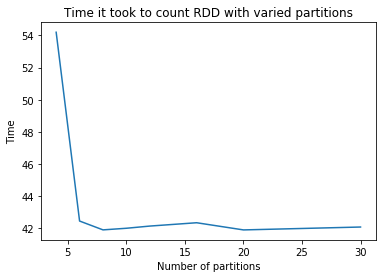

Number of documents:  2584


In [11]:
plt.plot(partition_speed[:,0], partition_speed[:,1])
plt.xlabel('Number of partitions')
plt.ylabel('Time')
plt.title('Time it took to count RDD with varied partitions')
plt.show()

print("Number of documents: ", no_of_documents)

- We can see that after 8 partitions there was no difference in the time it took to count the RDD. 
At the time, the cluster had 4 worker nodes so something around 2 $\times$ number of worker nodes
would have been a good start.
- As counting the RDD is a relatively simple task to compute we can't really see the advantage of 
adding extra partitions here. In general it's not good to have too few or too many partitions.
Too many partitions results in Spark scheduling too many tasks and creates a delay in performing any actual operations.

### Data Cleaning (Continuted)

In [12]:
# Procede with 8 partitions
# We now prepare the data as an RDD so that we can make use of Key,Value pair 
# operations. We merge the data such that we have (paper_id, *ALL* document text).

cord19rdd = cord19text.rdd.map(lambda x: (x[0],x[1])).reduceByKey(lambda x,y: x+y).partitionBy(8)
cord19rdd.take(1)                      

[('ff6d57f2aad99be129432058665b361dc18747e8',
  'Experiments were designed to test whether substances elaborated by MLC into the culture fluid would influence the susceptibility of resistant macrophages to MHV-PRI and whether direct cell-to-cell contact was necessary.The first experiment is summarized in Table I . In it, the effects of two groups of mixed lymphocyte cultures and the supernatant fluids of these cultures were tested on C3H macrophages. First, equal numbers (0.5 × l0 s) of PRI and C3H lymphocytes were mixed and added to C3H macrophages; than 10% supernatant fluids of the MLC were added to another pair of C3H macrophage cultures. Next, to test the possible transfer of susceptibility from the PRI to the C3H lymphocytes, spleen cells from the congenic, histocompatible but susceptible C3Hss strain were mixed with C3H lymphocytes, and this MLC was added to C3H macrophages. Finally, the supernatant fluid from the latter MLC was added to C3H macrophages. The C3H macrophages in e

In [13]:
# Our data contains multiple languages. Thus, we make use of NLTK's stopword collections
# to make sure that we filter out all stopwords for the main languages languages.

nltk_languages = stopwords.fileids()
print(nltk_languages)

['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [14]:
# Of these we select the most common languages, to cut down future running time of queries
nltk_languages = ['english','french', 'german', 'italian', 'spanish']

In [15]:
# Tokenize the words using the following function

stop_words = set(stopwords.words(nltk_languages))

table = str.maketrans('','', string.punctuation)
lmtzr = WordNetLemmatizer()

def get_tokens(text):
    
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # filter out stop words
    words = [w for w in stripped if not w in stop_words]
    # lemmatizing the words
    words = [lmtzr.lemmatize(w) for w in words]
    
    return (words)

In [16]:
# Without inspection of the words there are some obvious scientific paper terms that 
# we should remove as well as the standard stop words provided by NLTK.

custom_stopwords = ['et', 'al', 'table', 'figure', 'fig', 'thus', 'therefore', 'data', 'doi', 'science','']
stop_words = list(stop_words) + custom_stopwords

In [17]:
print('Number of Stopwords: ' + str(len(stop_words)) + '\n\n' +
      'Example of Stopwords: \n' + str(sample(stop_words,20)))

Number of Stopwords: 1100

Example of Stopwords: 
['avevate', 'sintiendo', 'negli', 'que', 'quelle', 'mais', 'mis', 'tienen', 'further', 'also', 'facessimo', 'having', 'um', 'manchen', 'abbia', 'stettero', 'sto', 'estamos', 'allen', 'dass']


In [18]:
# As some of the 'words' we may be interested in have numbers in them. Such as biological names or years.
# We have chosen to leave them in for now, we can deal with reference numbers later.

# Tokenize the words
cord19_tokenized = cord19rdd.map(lambda row: (row[0], get_tokens(row[1])))
cord19_tokenized.take(1)     

[('ff6d57f2aad99be129432058665b361dc18747e8',
  ['experiment',
   'designed',
   'test',
   'whether',
   'substance',
   'elaborated',
   'mlc',
   'culture',
   'fluid',
   'would',
   'influence',
   'susceptibility',
   'resistant',
   'macrophage',
   'mhvpri',
   'whether',
   'direct',
   'celltocell',
   'contact',
   'necessarythe',
   'first',
   'experiment',
   'summarized',
   'effect',
   'two',
   'group',
   'mixed',
   'lymphocyte',
   'culture',
   'supernatant',
   'fluid',
   'culture',
   'tested',
   'c3h',
   'macrophage',
   'first',
   'equal',
   'number',
   '05',
   '×',
   'l0',
   'pri',
   'c3h',
   'lymphocyte',
   'mixed',
   'added',
   'c3h',
   'macrophage',
   '10',
   'supernatant',
   'fluid',
   'mlc',
   'added',
   'another',
   'pair',
   'c3h',
   'macrophage',
   'culture',
   'next',
   'test',
   'possible',
   'transfer',
   'susceptibility',
   'pri',
   'c3h',
   'lymphocyte',
   'spleen',
   'cell',
   'congenic',
   'histocompatible',

In [19]:
# Let's take a look at the most common words in all of the texts.
# This might take a bit of time, but it will be useful to see if we missed any obvious stopwords.

wordsRDD = cord19_tokenized.flatMap(lambda row: row[1]) \
    .map(lambda word: (word,1)) \
    .reduceByKey(lambda a,b: a+b) \
    .sortBy(lambda a: -a[1]) \

wordsList = wordsRDD.collect()
wordsList[:150]

[('cell', 49534),
 ('study', 33968),
 ('virus', 31859),
 ('1', 29308),
 ('2', 28145),
 ('protein', 27435),
 ('patient', 25504),
 ('infection', 24838),
 ('disease', 21070),
 ('using', 19996),
 ('3', 19325),
 ('case', 17839),
 ('may', 17509),
 ('used', 17027),
 ('5', 16882),
 ('group', 16302),
 ('10', 15959),
 ('viral', 15113),
 ('result', 15096),
 ('human', 15010),
 ('4', 14495),
 ('health', 13195),
 ('one', 12949),
 ('sample', 12813),
 ('level', 12589),
 ('analysis', 12577),
 ('p', 12501),
 ('gene', 12355),
 ('day', 12275),
 ('two', 11989),
 ('treatment', 11956),
 ('however', 11954),
 ('number', 11926),
 ('time', 11849),
 ('dog', 11728),
 ('control', 11410),
 ('sequence', 11341),
 ('clinical', 11204),
 ('mouse', 10869),
 ('6', 10766),
 ('respiratory', 10240),
 ('response', 10125),
 ('different', 10120),
 ('rna', 10115),
 ('expression', 10111),
 ('antibody', 9970),
 ('reported', 9902),
 ('effect', 9667),
 ('system', 9615),
 ('model', 9350),
 ('b', 9132),
 ('shown', 8909),
 ('activity', 

- From the above let's use **8000** as the threshold for being a stopword, words above this are most likely not topic specific from inspection.
- To improve the results we could also cherry pick words that appear the most frequently, this would be extremely important given someone had plenty of domain knowledge.
- We also get rid of words that only are used once. These are most likely going to be noise not relevant to our analyses. 
- Something specific to our papers is going to be measurements e.g. 'cm', 'mm' and we choose discard these by getting rid of all words less than 3 letters. We also have reference numbers to remove as well.
- Notice that there exist some biological sequences such as 'TTATATAGGGGTTAGAACTTCATTTTTCCTTGTT'. Getting rid of words that only have a frequency of 1 will fix this due to their uniqueness. - Which we can address upon building our [CountVectorizer model](https://spark.apache.org/docs/latest/ml-features#countvectorizer) [5].

In [20]:
# Filter out words that appear too frequently
xtraStopWords = wordsRDD.filter(lambda a: a[1] > 8000).map(lambda r: r[0]).collect()


# Omit high frequency words and words less than 3 characters
cord19_new = cord19_tokenized \
    .map(lambda r: (r[0],[w for w in r[1] if not w in xtraStopWords and len(w)>2])) \
    .filter(lambda row: len(row[1]) > 0)

print("\nExample of words not discarded:\n")
cord19_new.take(1)[0][1][:10]


Example of words not discarded:



['porcine',
 'reproductive',
 'syndrome',
 'prrsv',
 'cause',
 'complex',
 'systemic',
 'pig',
 'primarily',
 'affect']

### Generate feature vectors with CountVectorizer

In [21]:
# Firstly, we make a dataframe to feed into the CountVectorizer model
# We cache this here to speed up execution of the computations in the next step

spark.catalog.clearCache()
cord19_words_df = spark.createDataFrame(cord19_new, ["paper_id","words"])
cord19_words_df.cache()
cord19_words_df.show(20)

+--------------------+--------------------+
|            paper_id|               words|
+--------------------+--------------------+
|ff6d57f2aad99be12...|[experiment, desi...|
|95f7c797080ddb8d4...|[despite, broad, ...|
|39a7144b3eb9ddf5b...|[current, estimat...|
|4564dfbcb341f91ca...|[footandmouth, fm...|
|7b9f9339ac1f541b5...|[supplementary, t...|
|7a0d4f63df57cc987...|[population, chal...|
|8c4233100da83790e...|[principal, media...|
|f242a1a7a7c8f4027...|[outbreak, severe...|
|be52ea1629f0b702f...|[panax, ginseng, ...|
|a621b8667d221681d...|[ransport, inhibi...|
|416c18fdc648694ae...|[since, detection...|
|2e8fcc213e690efe4...|[uman, rhinovirus...|
|bbb35eef3b6121c33...|[2003, 2015, radi...|
|1ed5058204d1330e7...|[acute, diarrhea,...|
|af7445b0b1d408a96...|[latest, report, ...|
|c0d27ee09b9a2e3d8...|[coronavirus, 201...|
|5e8abc62533a44742...|[increasing, prev...|
|6e4d9a7b61701ca96...|[ebola, outbreak,...|
|d873e54f68ff11110...|[neonatal, calf, ...|
|55f664e8e3b183889...|[several, 

In [22]:
# Initialise CountVectorizer model with our chosen parameters
# We set minDF=2 to omit terms that don't appear in at least 2 documents
# MinTF=2 will get rid of references due to their increasing nature,
# as there is only 1 reference number per ref.

cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2, minTF =2)

In [23]:
cv_model = cv.fit(cord19_words_df)

In [24]:
# Generate sparse vectors for the frequencies of words in each document
# We cache this dataframe as it is going to be a main reference point for
# all operations beyond this point. RDDs are lazily evaluated and we do 
# not want to recompute this everytime we want to run a task.

cord19_words_df_features = cv_model.transform(cord19_words_df)
cord19_words_df_features.cache()
cord19_words_df_features.show(10)

+--------------------+--------------------+--------------------+
|            paper_id|               words|            features|
+--------------------+--------------------+--------------------+
|ff6d57f2aad99be12...|[experiment, desi...|(73660,[5,7,8,12,...|
|95f7c797080ddb8d4...|[despite, broad, ...|(73660,[0,2,6,7,8...|
|39a7144b3eb9ddf5b...|[current, estimat...|(73660,[0,1,2,3,4...|
|4564dfbcb341f91ca...|[footandmouth, fm...|(73660,[0,2,5,6,7...|
|7b9f9339ac1f541b5...|[supplementary, t...|(73660,[1,7,16,19...|
|7a0d4f63df57cc987...|[population, chal...|(73660,[0,2,3,5,6...|
|8c4233100da83790e...|[principal, media...|(73660,[2,3,8,9,1...|
|f242a1a7a7c8f4027...|[outbreak, severe...|(73660,[1,2,7,10,...|
|be52ea1629f0b702f...|[panax, ginseng, ...|(73660,[3,4,5,6,8...|
|a621b8667d221681d...|[ransport, inhibi...|(73660,[0,2,3,7,8...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



Now that we have our data in a suitable format to feed into our [LDA model](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.LDA) [6], we move on to comparing the two algorithms for estimating the posterior distribution. After we have seen the differences between them, we will then move on to gaining insight into the corpus with the results of the fitted LDA model.

## 3. Experiments with Online and Batch Variational Bayes
***

Batch Variational Bayes (VB) works by taking multiple full passes through the dataset to learn and update the parameters each time. In comparison, Online VB takes only 1 full pass of the dataset and learns on mini batches of the corpus.
At a high level, it is obvious to see why Batch can be impractical for large datasets. Taking multiple passes through the entire dataset is computationally costly and we would like to opt for a more concise approach when trying to estimate the posterior. In the paper by Hoffman et al. (2011), it was shown that the Online VB algorithm converges much faster for large datasets.

Interestingly Spark has implemented a [Distributed Model version](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.DistributedLDAModel) [7] of the batch (em algorithm), so whilst it was shown in the Hoffman paper that Online seemed to converge faster, we suspect that by taking advantage of the fact we are using a cluster here the Batch implementation will be faster.

### For fixed topic size how does the training time vary?

We expect the Distributed model to converge much faster given that more resources are provided to tackle the corpus.

In [25]:
# Measure the training time of any number of LDA models
# We build it for one model. Spark seems to flag up errors when you pass 2 models
# of different optimizer type to the same function.

def measure_training_time(*models):
    
    time_array = np.zeros(len(models))
    
    for i in range(len(models)):
        start_time = time.time()
        model = models[i]
        model.fit(cord19_words_df_features)
        end_time = time.time()
        time_elapsed = end_time - start_time
        time_array[i] = time_elapsed
        
    return time_array

In [26]:
# Batch model to measure training time

lda_batch_tt = LDA(k=50, optimizer = 'em', seed = 50, maxIter=50)
batch_time_50 = measure_training_time(lda_batch_tt)

In [27]:
# Online model to measure training time

lda_online_tt = LDA(k=50, optimizer = 'online', seed = 50, maxIter=50)
online_time_50 = measure_training_time(lda_online_tt)

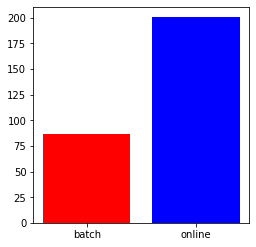

In [28]:
# Plot for Batch vs Online training time

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
fig.set_size_inches(3, 3)
methods = ['batch', 'online']
times = [batch_time_50[0], online_time_50[0]]
ax.bar(methods,times,color=['r','b'])
plt.show()

In [29]:
# Dummy models to show class of the model for different optimizers

batch_example = LDA(k=2, optimizer = 'em', seed = 50, maxIter=2)
batch_example_m = batch_example.fit(cord19_words_df_features)

print("\nIs batch distributed?\t", batch_example_m.isDistributed())

online_example = LDA(k=2, optimizer = 'online', seed = 50, maxIter=2)
online_example_m = online_example.fit(cord19_words_df_features)

print("Is online distributed?\t", online_example_m.isDistributed())


Is batch distributed?	 True
Is online distributed?	 False


As can be observed from the graph the distributed Batch implementation seems to converge much faster. It would be interesting to see the comparison if and when Spark implement a 'DistributedLDAModel' for the Online algorithm. 
Based on the literature, Hoffman et. al (2011), Online was seen to converge much faster in a level setting where the resources available were equal.

_DistributedLDAModel_ - Stores the inferred topics, the full training dataset, and the topic distribution for each training document.

_LocalLDAModel_ - Stores the inferred topics only; it does not store info about the training dataset.<br><br>

### How does topic size affect the training of Batch and Online?

In [30]:
# Function to compare the training time for each a set of topics on both online and batch algorithms
def compare_models_topics(topics, maxIterations):
    
    time_array = np.zeros(3*len(topics)).reshape(len(topics),3)
    
    for i in range(len(topics)):
        
        time_array[i][0] = topics[i]
        
        lda_batch = LDA(k=topics[i], optimizer='em', maxIter=maxIterations, seed=55)
        start_batch = time.time()
        lda_batch.fit(cord19_words_df_features)
        end_batch = time.time()
        batch_time = end_batch - start_batch
        time_array[i][1] = batch_time
        
        lda_online = LDA(k=topics[i], maxIter=maxIterations, optimizer='online', seed=22)
        start_online = time.time()
        lda_online.fit(cord19_words_df_features)
        end_online = time.time()
        online_time = end_online - start_online
        time_array[i][2] = online_time
        
    return time_array

In [31]:
times_array_topics = compare_models_topics([5,10,15,25,50], 20)

,Batch,Online
5.0,22.795119,13.759517
10.0,21.891127,20.288199
15.0,23.506699,27.175189
25.0,25.672289,40.520658
50.0,29.904530,77.929265


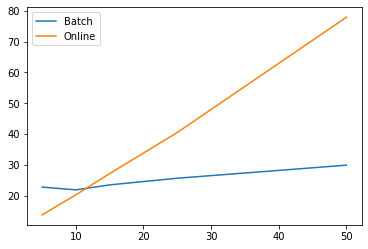

In [32]:
times_topics_df = pd.DataFrame({'Batch': times_array_topics[:, 1],
                   'Online': times_array_topics[:,2]}, index=times_array_topics[:,0])
times_graph = times_topics_df.plot.line(rot=0)

times_graph
times_topics_df

We can see that increased topic size increases Online training time by roughly the same amount each time whereas Batch seems to only increase slightly when trying to fit the data to more topics. The Spark Batch implementation seems to be more resillient to more topics.

### How does Perplexity change when the model is exposed to larger parts of the corpus?

In the paper by Hoffman et. al, it was show that perplexity natural drops off as the LDA algorithm is allowed to fit to a larger portion of the corpus. Let's see that effect here with the online algorithm. We can think of the perplexity as the geometric mean of the inverse marginal probability of each word in the test set of documents. Ultimately, a lower perplexity should indicate a better understanding of the test data.

$$ Perplexity(C_{test}) = \exp\left(- \frac{\sum_{d=1}^{M}\log{p(w_d)}}{\sum_{d=1}^{M}N_d}\right) $$

In [33]:
train_docs, test_docs = cord19_words_df_features.randomSplit([0.9,0.1], 22)

In [34]:
# Function to test model perplexity with more of the corpus to train on at each stage

def test_perplexity(model, train, test, portions):
    
    perplexities = np.zeros(portions)
    chunks = np.linspace(0.1,1,portions)
    
    for i in range(portions):
        document_portion = train_docs.sample(False, chunks[i], 22)
        lda_model = model.fit(document_portion)
        perplexities[i] = lda_model.logPerplexity(test)
    
    return perplexities

In [35]:
lda_online_perp = LDA(k=10, maxIter= 5, optimizer='online', seed=66)
lda_batch_perp = LDA(k=2, maxIter= 5, optimizer='em', seed=66)

In [36]:
online_perplexity = test_perplexity(lda_online_perp, train_docs, test_docs, 10)

In [37]:
tester = lda_batch_perp.fit(cord19_words_df_features.sample(False, 0.05, 22))

Text(0, 0.5, 'perplexity')

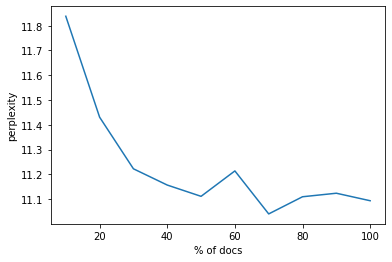

In [38]:
plt.plot(np.linspace(10,100,10), online_perplexity)
plt.xlabel('% of docs')
plt.ylabel('perplexity')

As perplexity is a measure of how well the model can predict a sample. We expect naturally that the more data the LDA model has access to, the better it should be a predicting a new sample. We can see this in the image above for the Online algorithm.

## 4. Fitting the LDA Model
***

A common heuristic to fit the LDA model to a corpus is to measure the average perplexity for each fold in K-fold cross validation for a set of various topics [8]. We build a function to do this below and give some insights into our corpus using the fitted model. To decide the number of topics when the number of topics is not known _a priori_ is an active area of research. Other heuristics do exist, the paper by Zhao et al. (2015) [9] proposes that a better method for deciding the number of topics is to measure the 'rate of perplexity change'.

### 1st Approach
We choose the the model with K topics that has the lowest perplexity.

In [39]:
# Function that does K-fold cross validation on the corpus
# Using perplexity as a measure of how well the model fits the corpus

def fit_lda_model_topics(topics, data, folds):
    
    partitions = np.ones(folds)*(1/folds)
    fold_list = data.randomSplit(partitions, 100)
    
    perplexities_arr = np.zeros((folds+1)*len(topics)).reshape(len(topics),folds+1)
    
    #For each holdout set - test the perplexity for *each* topic size given
    for i in range(len(fold_list)):
        test_set = fold_list[i]
        train_set = [fold for fold in fold_list if not fold==i]
        # union all dataframes in the train_set
        train_set_df = reduce(DataFrame.unionAll, train_set)
        
        for j in range(len(topics)):
            perplexities_arr[j][0] = topics[j]
            lda_online = LDA(k=topics[j], optimizer='online', seed=101)
            lda_online_model = lda_online.fit(train_set_df)
            perplexity = lda_online_model.logPerplexity(test_set)
            perplexities_arr[j][i+1] = perplexity
    
    return perplexities_arr

In [40]:
# Run the function to find the optimal number of topics
topics_p = [5,10,15,20,25,30,40]
topic_perplexities = fit_lda_model_topics(topics_p, cord19_words_df_features, 5)

In [41]:
# Gather and present the results about the perplexities
df = pd.DataFrame(topic_perplexities)
df['mean'] = df.mean(axis=1)
df.columns = ['topics', 'fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'mean perplexity']
df

,topics,fold1,fold2,fold3,fold4,fold5,mean perplexity
0,5.0,8.944105,8.986611,8.988493,8.933301,9.057098,8.318268
1,10.0,9.476966,9.516878,9.577254,9.402439,9.595757,9.594882
2,15.0,10.194646,10.244725,10.358332,10.006784,10.321317,11.020967
3,20.0,11.174023,11.235258,11.436192,10.860841,11.310491,12.669468
4,25.0,12.314035,12.386404,12.671560,11.872463,12.455449,14.449985
5,30.0,13.567313,13.656271,14.026573,12.959280,13.702706,16.318691
6,40.0,16.305692,16.457873,17.027031,15.412889,16.463485,20.277828


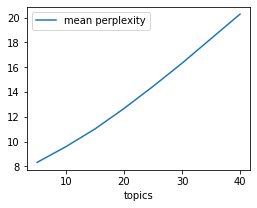

In [42]:
# GRAPH
df.plot(kind='line',x='topics',y='mean perplexity', figsize=(4, 3))

This approach seems to favour a much smaller topic size. This has it's disadvantages when you consider the size of our corpus. When splitting ~2500 documents, we would probably like to split this up into more topics than just 5. Let's explore what our 2nd approach says about the amount of topics we should have in our model.

### 2nd Approach

We use the RPC (Rate of Perplexity Change) which is explained in the paper by Zhao et al. (2015). The paper demonstrates that the first approach can be 'unstable'.

$$ RPC(i) = \left|\frac{P_i - P_{i-1}}{t_i - t_{i-1}}\right| $$

Where $P_i$ is the average perplexity for the i'th candidate topic $t_i$. The first $i$ that satisfies $RPC(i) < RPC(i+1)$ is chosen as the most appropriate number of topics.

Here we can cheat somewhat and use the results from the last function instead of computing everything again. Which is a very lengthy calculation and takes over 40 minutes for our topic size.

In [43]:
# pass a list of average perplexities and topics to calculate
# best number of topics with respect to RPC

def find_topics_rpc(perps, topics):
    
    RPC = np.zeros(len(perps)-1)
    
    best_rpc = 0
    
    for i in range(len(RPC)):
        RPC_i = np.abs((perps[i+1] - perps[i])/(topics[i+1] - topics[i]))
        RPC[i] = RPC_i
        
    return RPC

In [44]:
RPC = find_topics_rpc(list(df['mean perplexity']), topics_p)
RPCdf = pd.DataFrame(RPC, columns = ['RPC'])
RPCdf

,RPC
0,0.255323
1,0.285217
2,0.329700
3,0.356104
4,0.373741
5,0.395914


It seems unanimous! Even this kind of metric favours a lower number of topics.
Let's procede with say 6 topics to make things slightly more interesting. It is important to remember that these approaches are heuristics and domain knowledge will obviously trump any set method. We can see that the perplexity isn't that much different in a small topic range. To find out the true extent as to how much this matters for model fit would be interesting, but is out of the scope of this report.

## 5. Data Insights
***

We now delve into our topic model and see what the most relevant papers for each topic are about. We build convenient functions to find the top N papers for a given topic and provide a search function to get the contents of any paper. We start with looking at the most important words for each topic.

In [62]:
# Trying both EM and Online optimizer, em seemed to give more coherent words groupings
# It also allows us to make use of DistributedLDAModel 'transform' method

lda_final = LDA(k=6, optimizer = 'em', maxIter = 100)

In [63]:
lda_model_final = lda_final.fit(cord19_words_df_features)

### What are the top 10 words for each topic?

In [64]:
# Generate dataframe contraining most n important words for each topic
topics = lda_model_final.describeTopics(10)

print("\nThe topics described by their top-weighted terms:\n")

topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()

# Print most important words for each topic
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])


The topics described by their top-weighted terms:

['cat' 'concentration' 'blood' 'serum' 'significantly' 'tissue'
 'increased' 'associated' 'significant' 'healthy']
['child' 'symptom' 'year' 'pneumonia' 'age' 'severe' 'acute' 'rsv'
 'associated' 'pathogen']
['genome' 'structure' 'region' 'dna' 'site' 'acid' 'strain' 'assay'
 'target' 'mutation']
['outbreak' 'merscov' 'transmission' 'contact' 'risk' 'epidemic'
 'hospital' 'individual' 'population' 'infectious']
['research' 'development' 'use' 'pathogen' 'drug' 'approach' 'public'
 'new' 'need' 'training']
['membrane' 'receptor' 'min' 'pathway' 'surface' 'described' 'domain'
 'infected' 'immune' 'type']


### What are the most relevant documents for each topic?

In [65]:
# We now can obtain the topicDistribution for each paper

transformed = lda_model_final.transform(cord19_words_df_features)
tdf = transformed.select("paper_id","topicDistribution")
tdf.show(10)

+--------------------+--------------------+
|            paper_id|   topicDistribution|
+--------------------+--------------------+
|65a29504e9fb777de...|[0.12196807686302...|
|860ffcab2771f1935...|[0.17848163573782...|
|64d31d4587a861085...|[0.01232909783489...|
|d279bf13512bd679f...|[0.01509436510553...|
|defb3d3bd1f210f27...|[0.01288348380923...|
|9ceee77cb6dcbc0a9...|[0.13014568857277...|
|55461f69aec24f255...|[0.01649931193027...|
|f709c57759c73d920...|[0.47199765807200...|
|d6da8802866acb6cd...|[0.02590046635528...|
|2ab6f8a828ae542db...|[0.01618964669907...|
+--------------------+--------------------+
only showing top 10 rows



In [66]:
tdf.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [67]:
# As 'tdf' topicDistribution column is in vector form to perform various SQL transformations
# we need to convert it to an array. tdf_conv is the topicDistribution column expanded 
# where our new dataframe has a score for each paper in each topic. PAPER_ID | TOPIC1 SCORE | TOPIC2 SCORE | ...

import pyspark.sql.functions as F
import pyspark.sql.types as T

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

tdf_conv = tdf.withColumn('topicDistribution', to_array('topicDistribution'))

In [68]:
# DataFrame which has paper_ID | TOPIC1 SCORE | TOPIC2 SCORE | ...

tdf_final = tdf_conv.select('paper_id', tdf_conv.topicDistribution[0], 
                                        tdf_conv.topicDistribution[1],
                                        tdf_conv.topicDistribution[2],
                                        tdf_conv.topicDistribution[3],
                                        tdf_conv.topicDistribution[4],
                                        tdf_conv.topicDistribution[5])

In [69]:
# Create DF for just the 1st topic and sort it with most relevant document at the top

tdf_topic0 = tdf_final.select("paper_id","topicDistribution[0]") \
                      .withColumnRenamed("topicDistribution[0]", "topic0")

tdf_topic0_sorted = tdf_topic0.sort(desc('topic0'))

In [70]:
tdf_pandas0 = tdf_topic0_sorted.toPandas()
tdf_pandas0.head(10)

,paper_id,topic0
0,a02f53bba04cb55cd70c09e2299f3ab1556943fb,0.990730
1,52069d14f038d493dce5d6cc1fdcdc7c1f0823f9,0.989272
2,85dfb59af4c4ec824f1f62c645e5b91a6e3cc814,0.989136
3,6e99aa3d7287b2e04d3c2a975ba94212158ac45c,0.986826
4,25a10dcacb257ac926ad42124f605189b3789d3f,0.985082
5,35349bb1fc9290338907b7d7f104c9db3951163b,0.983326
6,b616293107ee48ebc8884fc55ebc66965df4feb8,0.981076
7,84dc4e9ee5f8dd324d2d436d7c07c7d0044a58a4,0.980592
8,0036b28fddf7e93da0970303672934ea2f9944e7,0.970113
9,c7a16d3975bbb4ad4f44786d1e5961d16d21f863,0.961703


In [71]:
query00 = cord19rdd.filter(lambda x: x[0] == '27d9e8f9f893c005e551b219680b7832eac40fca')

In [72]:
query00.take(1)

[('27d9e8f9f893c005e551b219680b7832eac40fca',
  "Hematopoietic stem cell transplantation (HSCT), known previously as bone marrow transplantation, is performed to treat two broad categories of diseases. The first category consists of functional failure of bone marrow or marrow-derived cells, including aplastic anemia, myelodysplastic syndrome, immunodeficiency syndromes (severe combined immune deficiency or chronic granulomatous disease), genetic diseases (mucopolysaccharidosis, glycogen storage diseases, etc.), or hemoglobinopathies (thalassemia, sickle cell anemia, etc.). In such cases, HSCT is applied to replace the de-fective, non-functional bone marrow tissues. Diseases in the second category-which includes hematologic malignancies such as acute or chronic leukemia, multiple myeloma, lymphomas, and myeloproliferative neoplasms-are more common indications for HSCT, the performance of which aims (1) to restore the myelosuppressive or myeloablative effect of cytotoxic treatment (such 

In [73]:
query01 = cord19rdd.filter(lambda x: x[0] == 'c424a72fd5308460bc3fc86044a65cae00a9c377')
query01.take(1)

[('c424a72fd5308460bc3fc86044a65cae00a9c377',
  "In December 2019, a cluster of patients with pneumonia of unknown etiology were identified in Wuhan, China. A previously unknown betacoronavirus was detected in respiratory samples from the patients. 1) The virus was named severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) and was deemed caused by coronavirus disease 2019 . 2) COVID-19 rapidly swept mainland China and spread worldwide, causing 118,319 confirmed cases and 4,292 deaths in 113 nations as of March 11, 2020 . The World Health Organization (WHO) declared COVID-19 a pandemic. 3) In the Republic of Korea, starting with a Chinese traveler from Wuhan in January 20, 4) 7,755 confirmed cases leading to 60 deaths have occurred as of March 11, 2020. 5) COVID-19 is a novel infectious disease that is forecasted to have an enormous effect worldwide. This article reviews what is known about COVID-19 in children and adolescents as of March 12, 2020 in an effort to help clinicians

In [74]:
#query02 = cord19rdd.filter(lambda x: x[0] == '24ec3df6486c04e0eb67d213475f3f1b20fe9fec')
#query02.take(1)

<div class="alert alert-block alert-info">
We can clearly see that this topic has managed to identify lots of articles regarding pneumonia and the various treatments. This is particularly important as the coronaviruses tend to lead to people getting pneumonia and dying. A good starting point would be to look at the articles that appear at the top of the dataframe for researching anything related to pneumonia.</div>

In [75]:
# Function to extract the top N articles for any topic.

def extract_top_articles(topic, N):
    
    tdf_topicX = tdf_final.select("paper_id","topicDistribution["+str(topic)+"]") \
                          .withColumnRenamed("topicDistribution["+str(topic)+"]", "topic"+str(topic))
    
    tdf_topicX_sorted = tdf_topicX.sort(desc('topic'+str(topic)))
    tdf_pandasX = tdf_topicX_sorted.toPandas()
    
    return tdf_pandasX.head(N)   

In [86]:
extract_top_articles(3,12)

,paper_id,topic3
0,44f01ea111fa2b4bd8ce34739f64b17930bb0ea8,0.985641
1,c9796b987137402c163bb03519d8cd9de9ae99f9,0.967279
2,013d9fb8719d3d3d47738f9f0604f3b643c4df57,0.954109
3,eb15925279f8a48013f2a51800d170a31bfe2402,0.945116
4,398bb77199ddb0d4e54efc14a1f1ef4c4ccb312b,0.945091
5,f2b1074882bd3bdb8794c79fb4ab6fb72fbbf2ee,0.939872
6,ab9abbe85c17fc97b9b10fefa729dae44c12c65d,0.933742
7,67db14be4e5b68f4d42496330429a1d86266a161,0.933297
8,9de8690f1b762460b4886a5732f27dba83800c26,0.928589
9,6e33bf088cfbcde318f35f3be8dea6810b0b96ce,0.927894


In [77]:
# Function to extract any paper by it's ID

def extract_article(paper_id):
    
    if(type(paper_id) != str):
        print('please enter a paper_id string')
        return

    query = cord19rdd.filter(lambda x: x[0] == paper_id)

    return query.take(1)

In [87]:
extract_article('44f01ea111fa2b4bd8ce34739f64b17930bb0ea8')

[('44f01ea111fa2b4bd8ce34739f64b17930bb0ea8',
  'This modelling study investigated the impact of an influenza pandemic on a community in Papua New Guinea (PNG) and compared it with that in a similar sized community in Australia. The effectiveness of social distancing interventions was determined using the PNG model and contrasted with the Australian model.A moderately transmissible pandemic occurring in PNG may be expected to result in a larger illness attack rate compared to that in a developed country setting.Feasible social distancing intervention strategies may be significantly less effective in PNG compared to the Australian setting. Compared to Australia, the larger household sizes contribute both to the larger attack rates in PNG and to the lower effectiveness of the interventions.The larger proportion of children in PNG and the fact that 50% do not attend school lessen the effectiveness of school closure interventions.Strength and limitations of this study The findings are a fi

In [88]:
extract_article('c9796b987137402c163bb03519d8cd9de9ae99f9')

[('c9796b987137402c163bb03519d8cd9de9ae99f9',
  'Objective When faced with an emergent epidemic with high mortality and morbidity potential, policy makers must decide what public health interventions to deploy at different stages of the outbreak.However, almost nothing is known about how the public view these interventions or how they trade off risks (of disease) with inconvenience (of interventions). In this paper, we aim to understand public perceptions on pandemic interventions, as well as to identify if there are any distinct respondent preference classes.Design A discrete choice experiment.Setting This study was fielded in Singapore between November 2012 and February 2013.Participants A random sample of 500 Singapore residents aged 21 and over, including 271 women and 229 men, was analysed.Outcome measures Demographic information was collected from each participant. Participants were also shown a series of pairs of alternatives, each combining interventions and morbidity, mortalit

<div class="alert alert-block alert-info"> As indicated by the words given for topic 3, this topic seems to have identified papers that mainly talk about how countries can control and handle epidemological transitions. This is obviously a huge topic for COVID-19 as for example, one of the main issues with this disease is controlling the spread. In the UK and in Italy we have seen rapid spread of the virus, the papers listed here may shed some light on how we can deal with the transition back into normal life.
</div>

In [80]:
extract_top_articles(4,4)

,paper_id,topic4
0,5738e88fe3a742f9f6f69919bd4e6b094d52eded,0.970257
1,0a098b3876e799d9b21608e26e80d05aa9ec6475,0.970214
2,c2d4efc02a8e37fb93eafe7ddb9eff42e0c600b2,0.958042
3,c98acd548c24c973cbad72af49a0080fce9cd2ee,0.954357


In [89]:
extract_article('5738e88fe3a742f9f6f69919bd4e6b094d52eded')

[('5738e88fe3a742f9f6f69919bd4e6b094d52eded',
  'The outbreak of the SARS (severe acute respiratory syndrome) epidemic in 2003 exposed serious deficiencies in Taiwan\'s health care and medical education systems. 1 The Department of Health (DOH), Executive Yuan therefore focused effort on implementation of the "Project of Reforming Taiwan\'s Medical Care and PublicHealthcare System" which includes strategies and methods for improving resident education and the quality of medical care. A project entitled the "Postgraduate General Medical Training Program" was further announced by the DOH in August 2003. In this project, each PGY 1 resident is required to complete a six-month training program before entering his or her subspecialist courses. 2 In 2006, Taiwan Association of Medical Education helped many teaching hospitals to establish "General Medical Training Demonstration Centers" as a means of improving medical education of clinical teachers, residents, and medical students. Additional

In [90]:
extract_article('0a098b3876e799d9b21608e26e80d05aa9ec6475')

[('0a098b3876e799d9b21608e26e80d05aa9ec6475',
  'This paper addresses the need for conceptual and analytic clarity on nutrition governance, an essential underpinning of more effective approaches for undernutrition, the \'single greatest constraint to global development\' and obesity, which already accounts for 4% of the world\'s disease burden and is growing rapidly. The governance of nutrition, which is essential to designing and implementing policies to realise the right to food, is among the most important and most defining duties of society. But research and action on nutrition governance are hampered by the absence of conceptual rigour, even as the continuing very high burden of undernutrition and the rapid rise in obesity highlight the need for such structures. The breadth of nutrition itself suggests that governance is both needed and sure to be complicated. This analysis explores the reasons attention has come to governance in development policy making, and why it has focused o

<div class="alert alert-block alert-info"> This topic seems to be more about drugs, solutions and past responses to pandemics. <div>

### Similar Articles

Another useful tool would be that if you were given an article, which other article is the most similar?

To do this we use something called the [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) [10]. It is a measure of how similar two probability distributions are. It has been successfully implemented by various papers, for example in the one by Tong et al. (2016) [11]. We state the Jenson-Shannon divergence as $JSDiv$ and the square root of that is the Jenson-Shannon distance. The Jenson-Shannon divergence is a symmetrized and smoothed version of the Kullback-Leibler divergence $D(P||Q)$.

$$ JSDiv(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M)$$

$$ M = \frac{1}{2}(P+Q) $$

$$ JSDist(P||Q) = \sqrt{JSDiv(P||Q)} $$

In [82]:
# Get an rdd such that we have (paper_id, [topic_distributions]) as K,V pairs

tdf_rdd = tdf_conv.rdd.map(lambda r: (r[0], r[1]))
tdf_rdd.take(1)

[('65a29504e9fb777dea5b6642112095999a8892ec',
  [0.12196871638298035,
   0.0965104028582573,
   0.42855343222618103,
   0.11344976723194122,
   0.09643054008483887,
   0.14308711886405945])]

In [83]:
# Function to return topic distribution of any paper

def get_topic_distribution(paper_id):
     
    return tdf_rdd.filter(lambda x: x[0] == paper_id).flatMap(lambda a: a[1]).collect()
    

In [84]:
from scipy.spatial import distance

# Get the M most similar articles with the Jenson Shannon distance
def get_similar_articles(new_dist, rdd, M):
    
    #smallest distances yield the most similarity
    JS = rdd.map(lambda x: (x[0],distance.jensenshannon(new_dist,x[1]))) \
                .sortBy(lambda a: a[1]) \
                .map(lambda x: x[0]) \
                .collect()
    
    return JS[1:M+1]

In [85]:
# These are the 5 most similar papers to our article

get_similar_articles(get_topic_distribution('65a29504e9fb777dea5b6642112095999a8892ec'),tdf_rdd, 5)

['1b7520912fbd483ef60014fe0e7f0d0c2df1d07e',
 '657558034931a24e09f761877fed36cb70f4f6fe',
 '4691859fba97c59b688292d6d2132d3ef1510e3a',
 'd040e6d03a6e02e8f21012e1fbd04b6d21da5284',
 '90a07d2dd8ed61a6605a0be5f7b5b738c82ad1f4']

#### Topics Summary
**Topic 0)** - Pneumonia, lung related diseases treatments and behaviours<br>
**Topic 1)** - Mostly Spanish articles (*highlights a flaw in our model*)<br>
**Topic 2)** - Studies on the behaviour of other major viruses<br>
**Topic 3)** - Outbreak, spreading of the disease and controlling the virus<br>
**Topic 4)** - Drugs and treatments for related diseases<br>
**Topic 5)** - Cell biology, proteins<br>

## 6. Conclusion
***
**Summary of Results**<br>

To speak generally about our findings, given that we had ~2500 documents we would have liked to have split the corpus into more parts than the 6 we ended up using. For explanation purposes it makes sense to keep the number of topics as concise as possible, it allows us to show the reader what is really possible with Spark's MLlib implementation of LDA. Our findings can easily be scaled to the larger CORD-19 dataset with a custom license and with more computing power and resources available, tasks should not take all that long.<br>

The running time of most queries that would be relevant to a researchers purposes such as finding relevant documents rarely took longer than a couple of minutes with our subset. An exception to this was fitting the LDA model, this was the most time consuming task as there are many hyperparameters involved leading up to building of the model and there are vastly different outcomes in terms of what the LDA model produces.<br> 

LDA models are notoriously hard to evaluate as there are no official performance metrics. In this report we provided two ways of deciding the optimal number of topics for a corpus. Using either of the heuristics shown and combining that with domain expertise is most likely the best way to fit any LDA model. We showed the stability and effectiveness of both LDA implementations in Spark (with respect to perplexity) and it was a shame that a DistributedLDAModel version of the online algorithm has not yet been implemented. For now the recommendation would be to use the 'em' optimizer as it clearly converges much faster in Spark and there are features to provide more interesting data analytics such as the 'transform' method.

To talk about our findings in the dataset, we managed to find 6 topics. Some more interesting than others, sorting by probability distribution scores for each topic was a sure way to find articles relevant to a topic. Topic 4 and 5 were particularly interesting as they contained information about treatment of coronaviruses and how to control the spread of a deadly virus, something of paramount importance in the current environment.

The most critical finding in this report was that we can find similar articles based on topic distributions. If a researcher needed to find other related articles to their work, they could simply use the mechanism provided in this report to compare any document (with the correct probability distribution conversion) to the topic distributions in our corpus and utilise the Jensen-Shannon distance to find the 'closest' article.


**Future Work**<br>

A drawback to this dataset is that it's multilingual, future work could look at filtering the corpus into set languages. A way to do this could be to find common stopwords for a language X and if a document included a small percentage of those words then you could classify that article as X. <br>

Fitting LDA models is a very tough task indeed, interested parties could look at tuning the hyperparameters for LDA and the respective CountVectorizer model. Specifically they could change parameters such as $minTF$ and $minDF$ in the CV model or add in extra parameters to LDA such as $subsampling rate$ for online LDA (which is the fraction of the corpus to be sampled and used in each iteration of mini-batch stochastic gradient descent). They could also manually adjust the $\alpha$ (document concentration over topics) and $\beta$ (topic distribution over words) values. Lastly, another suggestion would be to cherry pick stopwords and test the effect it has on the output of LDA. In addition to this it would be interesting to see what domain experts think about the effectiveness of an LDA model with more topics on this corpus, disregarding perplexity. <br>

A question that I have coming away from this report is how much does perplexity really matter? Is it a valid metric for evaluating topic models? There seems to be conflicting evidence online about this with some claiming that it is in fact not valid and some saying that it works for them. In addition to this, how much does a small amount of perplexity difference truly mean in terms of the models understanding of the corpus.  Future work would perform numerical evaluations and insight into this.

<div class="alert alert-block alert-info">Note: Keep an eye on the latest Spark documents for further features being added, it seems that most of Spark's LDA implementation is experimental and will most likely be updated in the near future. I am confident about this because when comparing it to other popular NLP libraries such as Gensim or PyLDAvis, the features are definitely lacking.</div>

## References
***

[1] Dataset - https://www.semanticscholar.org/cord19

[2] Blei, David M., Andrew Y. Ng, and Michael I. Jordan. "Latent dirichlet allocation." _Journal of machine Learning research_ 3.Jan (2003): 993-1022.

[3] Hoffman, Matthew, Francis R. Bach, and David M. Blei. "Online learning for latent dirichlet allocation." _advances in neural information processing systems_. 2010.



[4] Stopwords - https://en.wikipedia.org/wiki/Stop_words

[5] CountVectorizer - https://spark.apache.org/docs/latest/ml-features#countvectorizer

[6] LDAModel - https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.LDA

[7] DistributedLDAModel - https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.clustering.DistributedLDAModel

[8] Trabelsi, Amine, and Osmar R. Zaïane. "A joint topic viewpoint model for contention analysis." _International Conference on Applications of Natural Language to Data Bases/Information Systems_. Springer, Cham, 2014.

[9] Zhao, Weizhong, et al. "A heuristic approach to determine an appropriate number of topics in topic modeling." _BMC bioinformatics_. Vol. 16. No. 13. BioMed Central, 2015.

[10] Jenson-Shannon Divergence https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence

[11] Tong, Zhou, and Haiyi Zhang. "A text mining research based on LDA topic modelling." _Proceedings of the Sixth International Conference on Computer Science, Engineering and Information Technology (CCSEIT)_. 2016.